In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np

In [39]:
api = wandb.Api()
runs = api.runs('hiue/lowrank-fedrec-2', {
    "$and": [{
        # 'config.data.name': 'movielens',
        # 'config.dataloader.batch_size': 32,
        # 'config.data.name': 'foursq-ny',
        # 'config.task_name': 'fedsweep3',
        # 'config.dataloader.batch_size': 16,
        # 'config.trainer.lr': 5e-3,

        # 'config.data.name': 'foursq-ny',
        # 'config.dataloader.batch_size': 16,
        # 'config.trainer.lr': 7e-3,
        'tags': {
            "$in": ['selected']
        },
        'config.data.name': 'book-crossing',
        'config.task_name': 'fedsweep3',    
        # 'state': 'finished'
        }]
})

In [40]:
lora_runs = []
svd_runs = []
normal_runs = []

update_numels = []
all_HR = []
all_NDCG = []
all_loss = []

histories = {}

for run in runs:
    print("Name: {}, Id: {}".format(run.name, run.id))
    if 'lora' in run.name:
        if run.config['model']['init']['lora_rank'] == run.config['model']['init']['lora_alpha']:
            lora_runs.append(run)
        else:
            continue
    elif 'svd' in run.name:
        svd_runs.append(run)
    else:
        normal_runs.append(run)
        run.history()
    update_numels.append(run.summary['update_numel'])
    histories[run.name] = run.history()
    # all_HR.append(run.history()['HR'].max())
    # all_NDCG.append(run.history()['NDCG'].max())
    # all_loss.append(run.history()['train_loss'].min())

Name: fedmf64_lora32_freezeB-228-2-196, Id: 1q0qm37y
Name: fedmf64_lora16_freezeB-228-2-194, Id: 3n1zw0cd
Name: fedmf32-228-2-193, Id: kqs9pyaj
Name: fedmf16-228-2-189, Id: 3teo57pf
Name: fedmf64_lora8_freezeB-228-2-188, Id: 14qdsky2
Name: fedmf8-228-2-187, Id: 1j34ks40
Name: fedmf64_lora4_freezeB-228-2-184, Id: 3gchokxy
Name: fedmf4-228-2-181, Id: hoe9nmom


In [71]:
def scatter_plot(ax, runs, metric, label=None, marker='o', linestyle='dashed', color=None, rescale_x=None, min_value=False, text_offset=0.02):
    x = []
    y = []
    for run in runs:
        x_val = run.summary['update_numel']
        if rescale_x is not None:
            x_val = x_val / rescale_x
        x.append(x_val)

        y_val = run.summary[metric]
        # if min_value:
        #     y.append(histories[run.name][metric].min())
        # else:
        #     y.append(histories[run.name][metric].max())
        y.append(y_val)
        if 'lora' in run.name:
            lora_rank = run.config['model']['init']['lora_rank']
            # ax.text(x_val, y_val+text_offset, f"r={lora_rank}", fontsize=8)
            ax.annotate(f"r={lora_rank}", (x_val, y_val), xytext=(x_val, y_val+text_offset), fontsize=8)
        else:
            emb_size = run.config['model']['init']['gmf_emb_size']
            ax.text(x_val, y_val-text_offset, f"d={emb_size}", fontsize=8)

    ids = np.argsort(x)
    x = np.array(x)[ids]
    y = np.array(y)[ids]
    ax.plot(x, y, label=label, marker=marker, linestyle=linestyle, color=color)

(0.4, 0.6)

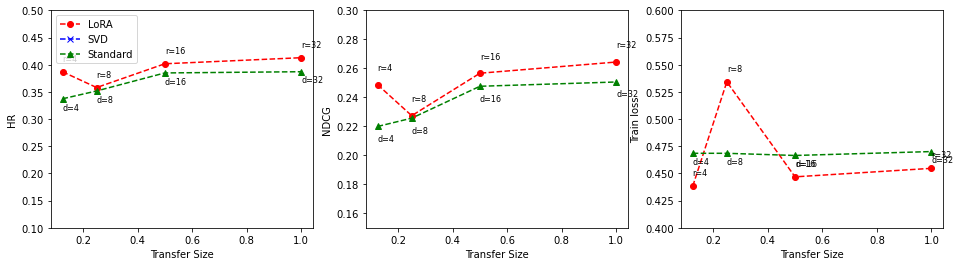

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
scatter_plot(axes[0], lora_runs, 'HR', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), text_offset=0.02)
scatter_plot(axes[0], svd_runs, 'HR', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), text_offset=0.02)
scatter_plot(axes[0], normal_runs, 'HR', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), text_offset=0.02)
axes[0].set_xlabel('Transfer Size')
axes[0].set_ylabel('HR')
axes[0].legend()
axes[0].set_ylim([0.1, 0.5])
# axes[0].axhline(y=max(all_HR), color='black', linestyle='-.')

scatter_plot(axes[1], lora_runs, 'NDCG', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), text_offset=0.01)
scatter_plot(axes[1], svd_runs, 'NDCG', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), text_offset=0.01)
scatter_plot(axes[1], normal_runs, 'NDCG', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), text_offset=0.01)
axes[1].set_xlabel('Transfer Size')
axes[1].set_ylabel('NDCG')
axes[1].set_ylim([0.15, 0.3])
# axes[1].axhline(y=max(all_NDCG), color='black', linestyle='-.')


scatter_plot(axes[2], lora_runs, 'train_loss', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
scatter_plot(axes[2], svd_runs, 'train_loss', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
scatter_plot(axes[2], normal_runs, 'train_loss', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
axes[2].set_xlabel('Transfer Size')
axes[2].set_ylabel('Train loss')
axes[2].set_ylim([0.4, 0.6])

In [30]:
fig.savefig('lastfm_transfer_size_max_metric.pdf', bbox_inches='tight')